In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
# subjects = [1]
n_subjects = len(subjects)

# fitting_type = 'texture_pyramid_ridge_4ori_4sf_pca_HL'
fitting_type = 'texture_pyramid_ridge_4ori_4sf_pca_HL_allsubsets'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois


In [3]:
port = 44442
summary_plots.plot_summary_pycortex(fitting_type, out, port, roi_def=None)

navigate browser to: 127.0.0.1:44442
Started server on port 44442
Stopping server


In [4]:
# Make plots in pycortex for variance partitioning analysis
# Full variance partition over all subsets

import cortex
from utils import numpy_utils

port=44442

title = '%s, %s'%(summary_plots.get_substr(out), fitting_type);

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

for si, ss in enumerate(subjects):

    names += ['S%d: Full model (sqrt R2)'%ss]
    maps += [np.sqrt(out[si]['val_r2'][:,0])]
    cmaps += ['PuBu']
    mins += [0]
    maxes += [0.60]

    ff_inds = np.arange(15,29)
    n_submodels = len(ff_inds)

    val_r2 = out[si]['val_r2']
    var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
    ve_names = ['Unique: ' + out[si]['partial_version_names'][ff].split('leave_out_')[1] \
                                 for ff in ff_inds]
    ve_names = ['S%d: '%ss + vn for vn in ve_names]
    names += ve_names
    maps += [np.sqrt(var_expl[:,ff]) for ff in range(n_submodels)]
    cmaps += ['PuBu' for ff in range(n_submodels)]
    mins += [0 for ff in range(n_submodels)]
    maxes += [0.2 for ff in range(n_submodels)]
    
    names += ['S%d: Preferred feature type (max unique var)'%ss]
    maps += [np.argmax(var_expl, axis=1).astype(np.float32)]
    cmaps += ['plasma_r']
    mins += [0]
    maxes += [n_submodels+1]

    vox2plot.append(out[si]['val_r2'][:,0]>0.01)
    
    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]
    
# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]



voxel_mask = [o['voxel_mask'] for o in out]
nii_shape = [o['brain_nii_shape'] for o in out]
volume_space = out[0]['volume_space']

pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=None, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442
Stopping server


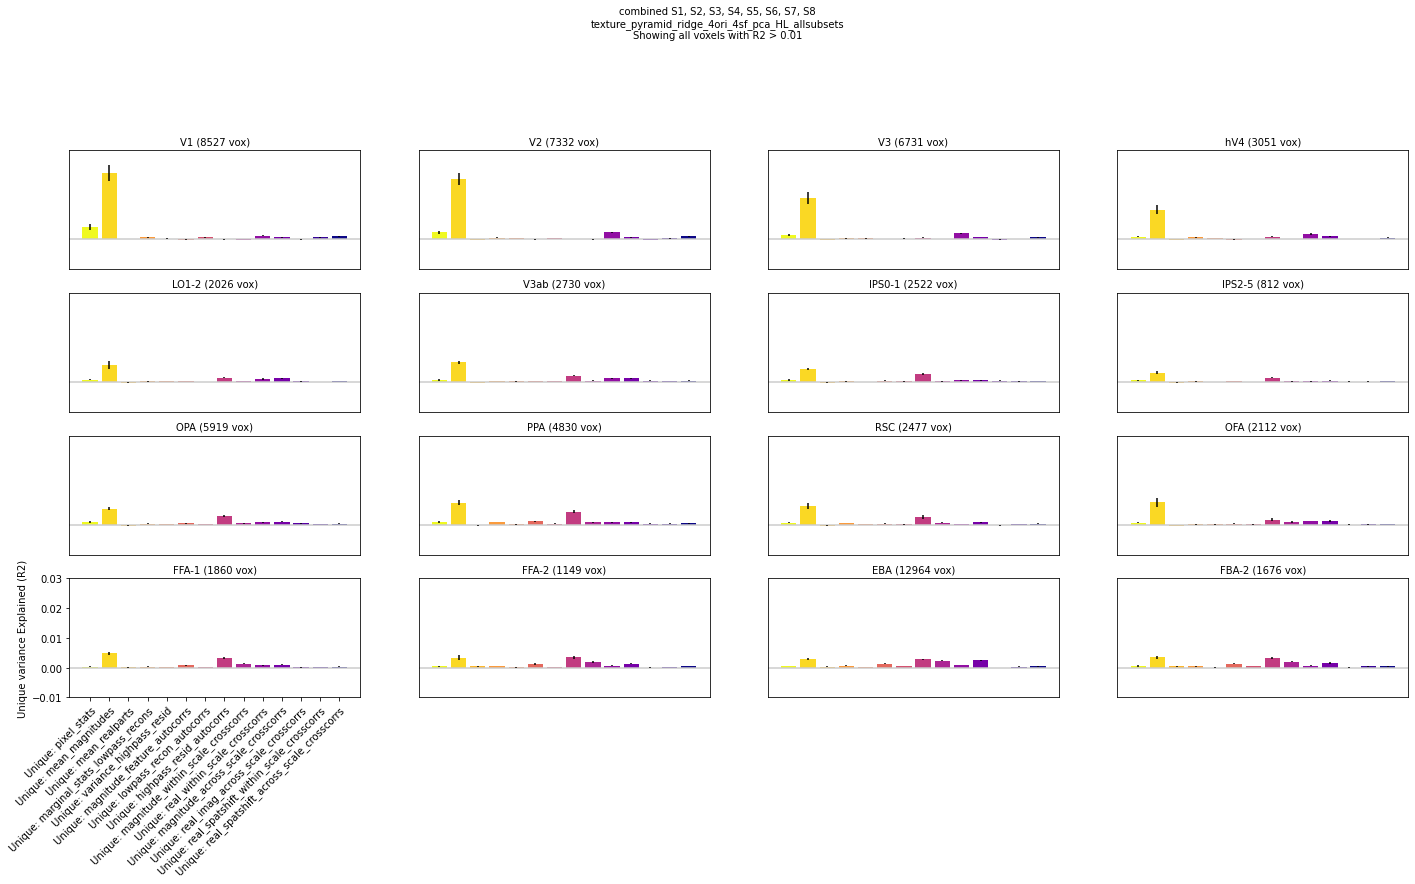

In [3]:
plot_utils.set_all_font_sizes(fs = 10)
r2_cutoff = 0.01

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 

ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
ve_names = ['Unique: ' + out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]
colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

inds2use = val_r2[:,0]>r2_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Unique variance Explained (R2)',\
                  horizontal_line_pos=0, ylims=[-0.010, 0.030])

plot_utils.create_roi_subplots(var_expl, inds2use, bp, roi_def=roi_def,\
                    subject_inds=subject_inds,\
                    suptitle='%s\n%s\nShowing all voxels with R2 > %.2f'%\
                               (summary_plots.get_substr(out), fitting_type, r2_cutoff))

plt.gcf().subplots_adjust(bottom=0.5)


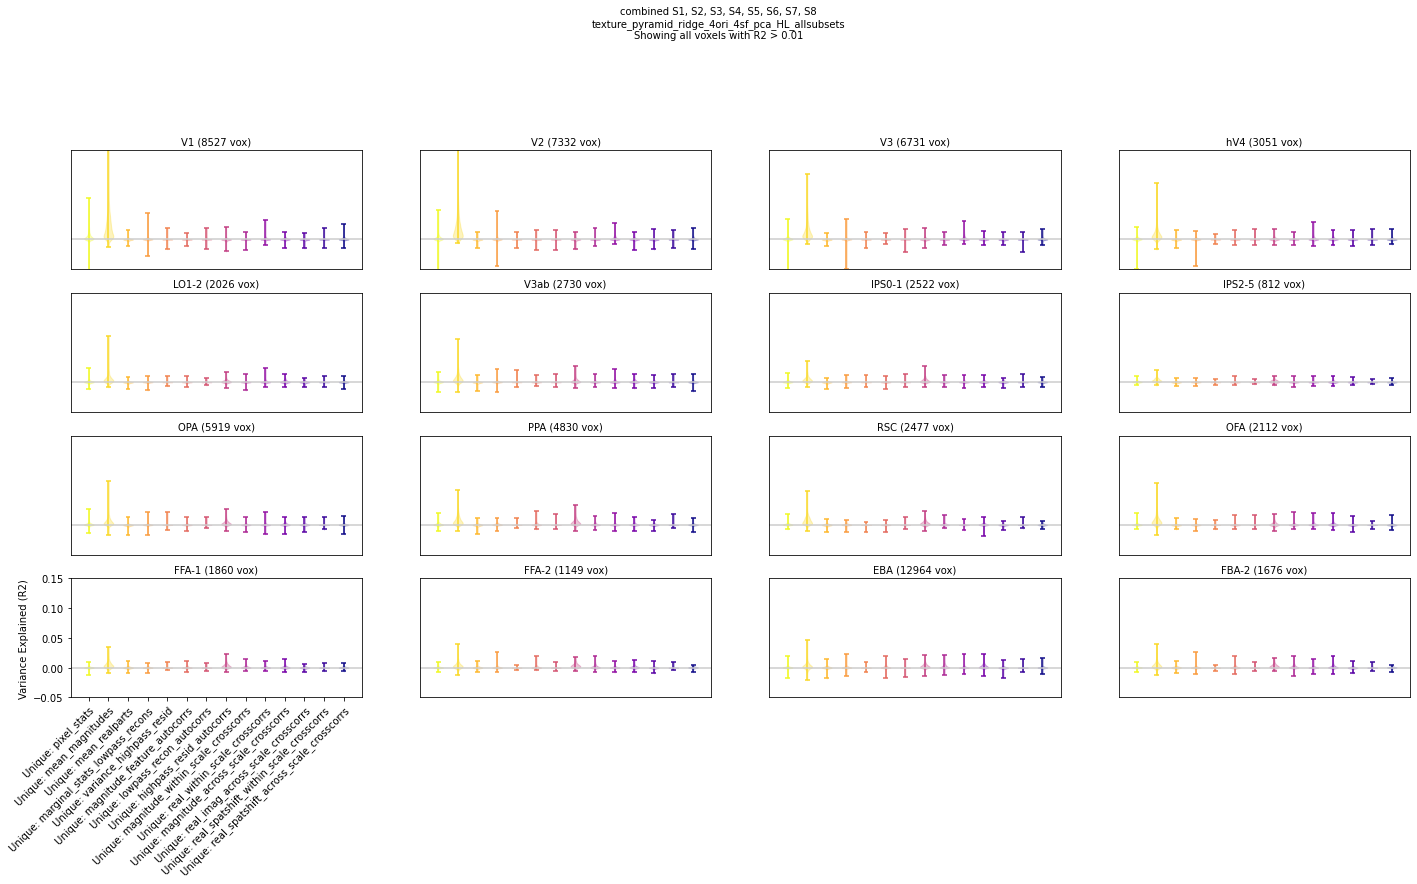

In [4]:
plot_utils.set_all_font_sizes(fs = 10)
r2_cutoff = 0.01

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 

ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
ve_names = ['Unique: ' + out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]
colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = val_r2[:,0]>r2_cutoff

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)',\
                  horizontal_line_pos=0, ylims=[-0.050, 0.150])

plot_utils.create_roi_subplots(var_expl, inds2use, vp, roi_def=roi_def, \
                    suptitle='%s\n%s\nShowing all voxels with R2 > %.2f'%(summary_plots.get_substr(out), fitting_type, r2_cutoff))

plt.gcf().subplots_adjust(bottom=0.5)


In [5]:
# check if variance explained is related at all to the dim of features


feature_types_all = ['pixel_stats', 'mean_magnitudes', 'mean_realparts', \
                     'marginal_stats_lowpass_recons', 'variance_highpass_resid', \
                     'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', \
                     'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', \
                     'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', \
                     'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
feature_type_dims_all = [6,16,16,10,1,272,73,25,24,24,48,96,10,20]


Text(0, 0.5, 'n features in subset (before PCA)')

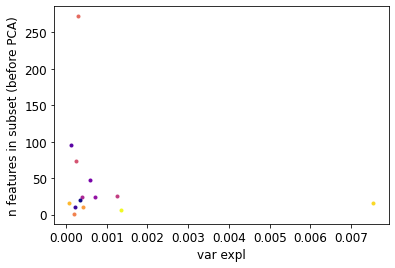

In [7]:
val_r2 = out[0]['val_r2']
ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)
colors = cm.plasma(np.linspace(0,1,n_submodels))
colors = np.flipud(colors)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
plt.figure();
for ff in range(n_submodels):
    plt.plot(np.mean(var_expl[:,ff], axis=0), feature_type_dims_all[ff],'.',color=colors[ff,:])
    
plt.xlabel('var expl')
plt.ylabel('n features in subset (before PCA)')

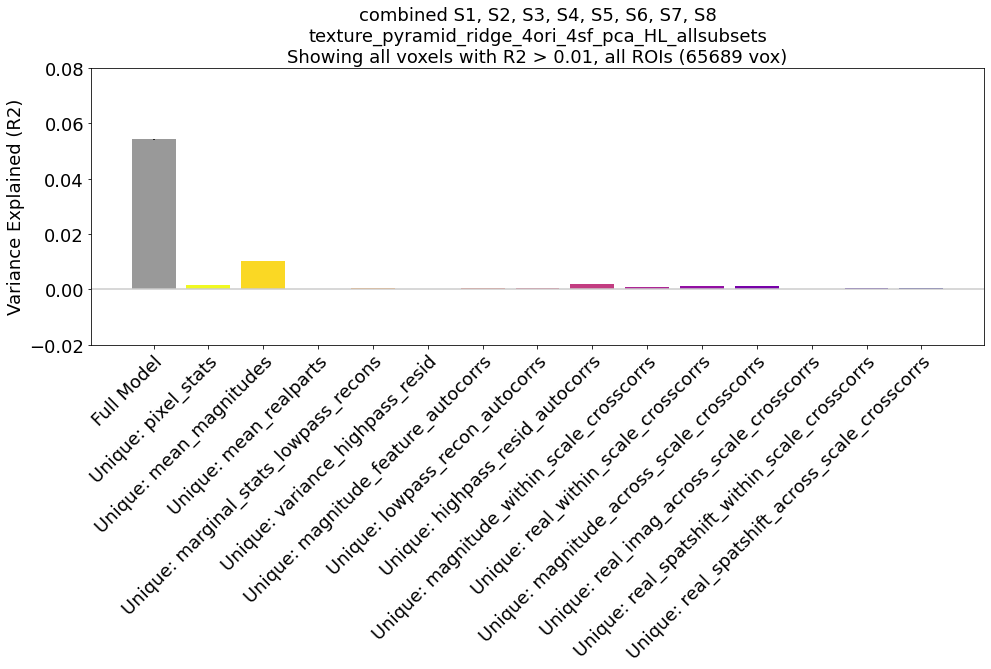

In [9]:
r2_cutoff=0.01

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0)
ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique: ' + out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)


inds2use = val_r2[:,0]>r2_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='%s\n%s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%\
                         (summary_plots.get_substr(out), fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.08])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.png'))
#     plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.pdf'))


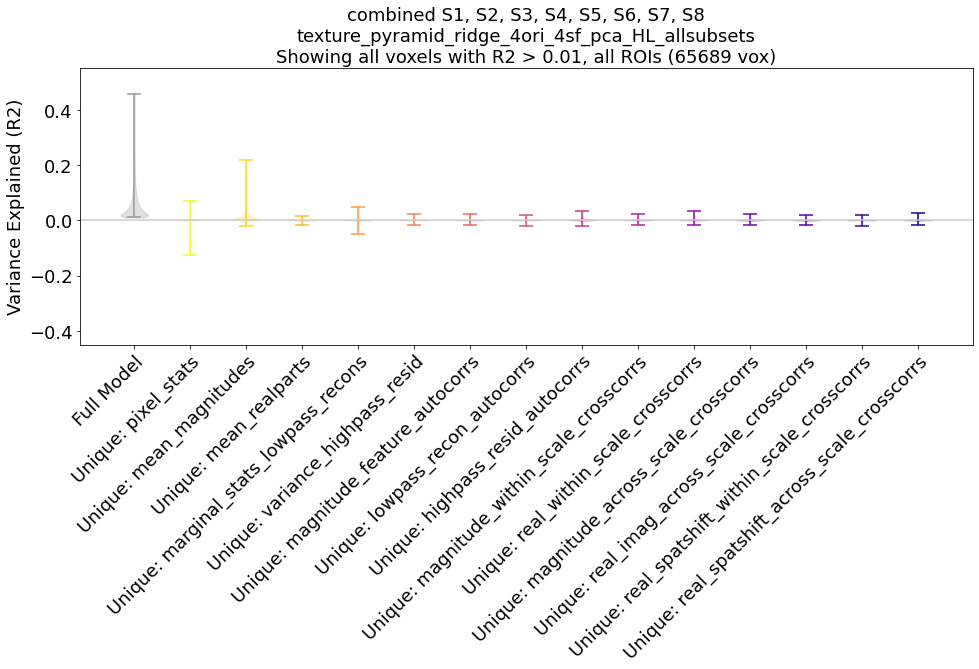

In [10]:
r2_cutoff=0.01

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0)
ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique: ' + out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)


inds2use = val_r2[:,0]>r2_cutoff

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='%s\n%s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%\
                         (summary_plots.get_substr(out), fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)),\
                                                        horizontal_line_pos=0, ylims=[-0.45, 0.55])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)


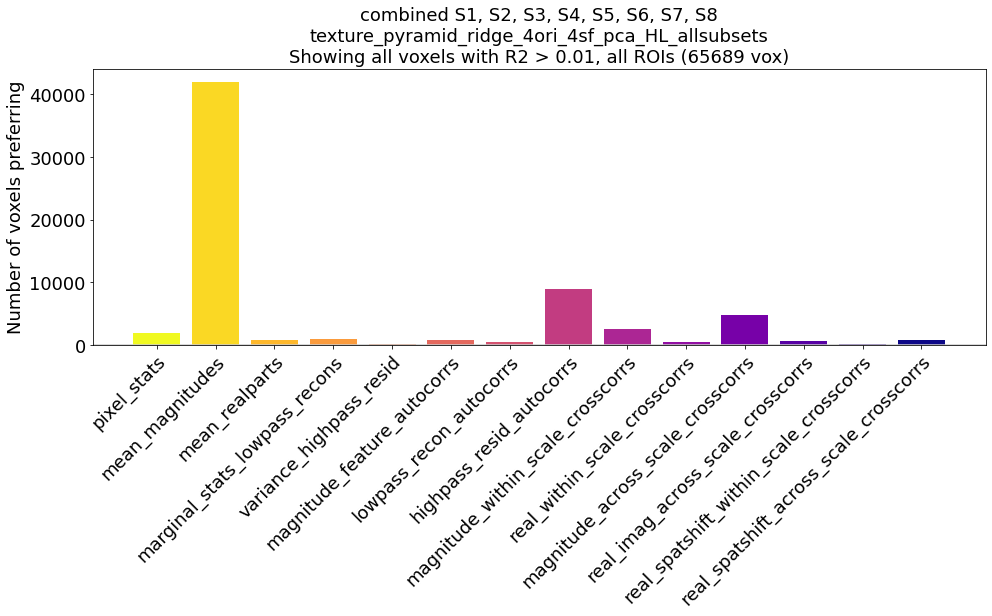

In [12]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.01

ff_inds = np.arange(15,29)
n_submodels = len(ff_inds)
n_feature_types = n_submodels

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
max_ve  = np.argmax(var_expl, axis=1)

inds2use = val_r2[:,0]>r2_cutoff

unvals = np.arange(0,n_feature_types)
counts = np.array([np.sum(np.logical_and(max_ve==ff, inds2use)) for ff in unvals])
counts = counts[np.newaxis,:]

ve_names = [out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]
colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels preferring', \
                 title='%s\n%s\nShowing all voxels with R2 > %.2f, all ROIs (%d vox)'%\
                         (summary_plots.get_substr(out), fitting_type, \
                                                        r2_cutoff, np.sum(inds2use)),\
                                                        horizontal_line_pos=0, ylims=None)
bp.create(data=counts, new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
